In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def total_energy(S, J=1.0):
    """Total energy with periodic BC. (Counts each bond once.)"""
    E = 0.0
    E -= J * np.sum(S * np.roll(S, shift=1, axis=0))
    E -= J * np.sum(S * np.roll(S, shift=1, axis=1))
    return float(E)


def metropolis_step(S, beta, J=1.0, current_energy=None, rng=None):
    """One attempted single-spin flip."""
    if rng is None:
        rng = np.random.default_rng()

    N = S.shape[0]
    if current_energy is None:
        current_energy = total_energy(S, J=J)

    i = rng.integers(0, N)
    j = rng.integers(0, N)

    s_ij = S[i, j]
    nn_sum = (
        S[(i + 1) % N, j] +
        S[(i - 1) % N, j] +
        S[i, (j + 1) % N] +
        S[i, (j - 1) % N]
    )

    dE = 2.0 * J * s_ij * nn_sum

    # accept/reject
    if dE <= 0.0 or rng.random() < np.exp(-beta * dE):
        S[i, j] = -s_ij
        current_energy += dE

    return S, current_energy


def metropolis_sweep(S, T, J=1.0, current_energy=None, rng=None):
    """
    One sweep: N^2 attempted single-spin flips for an N x N lattice.
    """
    if rng is None:
        rng = np.random.default_rng()

    N = S.shape[0]
    if current_energy is None:
        current_energy = total_energy(S, J=J)

    beta = 1.0 / T
    for _ in range(N * N):
        S, current_energy = metropolis_step(
            S, beta, J=J, current_energy=current_energy, rng=rng
        )

    return S, current_energy

In [3]:
def autocorrelation_fft(x):
    """
    Normalized ACF using FFT.
    """
    x = np.asarray(x, dtype=np.float64)
    n = len(x)
    if n < 2:
        return np.ones(n, dtype=np.float64)

    x = x - np.mean(x)

    n2 = 1 << (2 * n - 1).bit_length()
    f = np.fft.fft(x, n=n2)
    acf = np.fft.ifft(f * np.conjugate(f)).real[:n]

    # unbiased normalization 
    acf /= np.arange(n, 0, -1)

    # normalize
    acf /= acf[0]
    return acf


def tau_int_window(rho, c=8):
    """
    Integrated autocorrelation time with windowing method.
    """
    rho = np.asarray(rho, dtype=np.float64)
    tau = 0.5
    for t in range(1, len(rho)):
        if t > c * tau:
            break
        tau += rho[t]
    return float(tau)


In [4]:
def run_timeseries(L, T, n_burn=1000, n_meas=5000, thin=1, J=1.0, seed=None):
    """
    Returns equilibrium time series samples.
    """
    rng = np.random.default_rng(seed)

    S = rng.choice([-1, 1], size=(L, L))
    energy = total_energy(S, J=J)
    Nspin = L * L

    # burn-in 
    for _ in range(n_burn):
        S, energy = metropolis_sweep(S, T, J=J, current_energy=energy, rng=rng)

    E_series = np.empty(n_meas, dtype=np.float64)
    M_series = np.empty(n_meas, dtype=np.float64)

    for k in range(n_meas):
        for _ in range(thin):
            S, energy = metropolis_sweep(
                S, T, J=J, current_energy=energy, rng=rng)

        E_series[k] = energy / Nspin
        M_series[k] = abs(np.sum(S)) / Nspin  

    return E_series, M_series


def tau_for_temperature(L, T, n_rep=5, n_burn=1500, n_meas=6000, thin=1, J=1.0, c=8, base_seed=42):
    """
    Run multiple independent chains at the same T and return
    median tau_int for energy and magnetization.
    tau_sweeps = tau_recorded * thin
    """
    tauE_list = []
    tauM_list = []

    for r in range(n_rep):
        seed = base_seed + 10000 * r + int(1000 * T)  
        E, M = run_timeseries(L, T, n_burn=n_burn,
                              n_meas=n_meas, thin=thin, J=J, seed=seed)

        rhoE = autocorrelation_fft(E)
        rhoM = autocorrelation_fft(M)

        tauE = tau_int_window(rhoE, c=c) * thin 
        tauM = tau_int_window(rhoM, c=c) * thin

        tauE_list.append(tauE)
        tauM_list.append(tauM)

    return float(np.median(tauE_list)), float(np.median(tauM_list))


def tau_vs_temperature(L, temperatures, n_rep=5, n_burn=1500, n_meas=6000, thin=1, J=1.0, c=8):
    tauE = np.empty(len(temperatures), dtype=np.float64)
    tauM = np.empty(len(temperatures), dtype=np.float64)

    for i, T in enumerate(temperatures):
        tE, tM = tau_for_temperature(
            L, T,
            n_rep=n_rep, n_burn=n_burn, n_meas=n_meas, thin=thin,
            J=J, c=c, base_seed=42
        )
        tauE[i] = tE
        tauM[i] = tM
        print(f"T={T:.3f}  tau_E={tE:.2f} sweeps   tau_|M|={tM:.2f} sweeps")

    return tauE, tauM

In [5]:
def plot_spins(S):
    plt.figure()
    plt.imshow(S, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="spin")
    plt.title("Ising spin configuration")
    plt.axis("off")
    plt.show()


def local_energies(S, J=1.0):
    nn_sum = (
        np.roll(S, shift=1, axis=0) +
        np.roll(S, shift=-1, axis=0) +
        np.roll(S, shift=1, axis=1) +
        np.roll(S, shift=-1, axis=1)
    )
    E_local = -0.5 * J * S * nn_sum
    return E_local

T=1.200  tau_E=1.40 sweeps   tau_|M|=1.42 sweeps
T=1.433  tau_E=1.40 sweeps   tau_|M|=1.44 sweeps
T=1.667  tau_E=2.13 sweeps   tau_|M|=2.35 sweeps
T=1.900  tau_E=2.82 sweeps   tau_|M|=4.31 sweeps
T=1.900  tau_E=2.82 sweeps   tau_|M|=4.31 sweeps
T=2.000  tau_E=3.77 sweeps   tau_|M|=7.87 sweeps
T=2.100  tau_E=7.51 sweeps   tau_|M|=15.94 sweeps
T=2.200  tau_E=35.50 sweeps   tau_|M|=48.87 sweeps
T=2.300  tau_E=51.14 sweeps   tau_|M|=84.80 sweeps
T=2.400  tau_E=23.07 sweeps   tau_|M|=34.28 sweeps
T=2.500  tau_E=13.30 sweeps   tau_|M|=32.69 sweeps
T=2.600  tau_E=5.09 sweeps   tau_|M|=12.77 sweeps
T=2.600  tau_E=5.09 sweeps   tau_|M|=12.77 sweeps
T=2.900  tau_E=2.35 sweeps   tau_|M|=6.16 sweeps
T=3.200  tau_E=2.09 sweeps   tau_|M|=4.50 sweeps
T=3.500  tau_E=1.46 sweeps   tau_|M|=2.34 sweeps


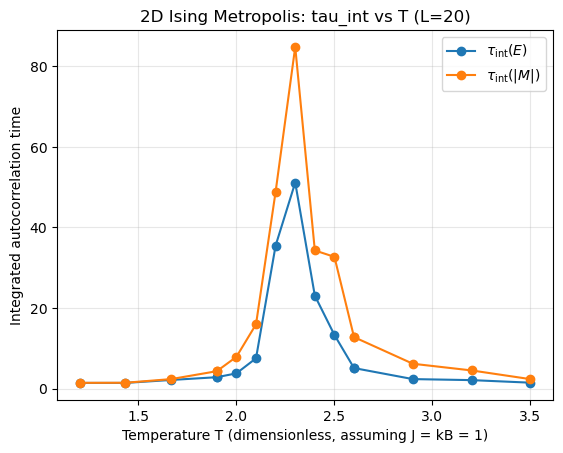

In [6]:

L = 20
J = 1.0

temperatures = np.concatenate([
        np.linspace(1.2, 1.9, 4),
        np.linspace(1.9, 2.6, 8),
        np.linspace(2.6, 3.5, 4)
    ])

n_rep = 2        # repeat chains per T and take median
n_burn = 500    # burn-in sweeps
n_meas = 1500    # number of recorded points
thin = 2
c = 8            # window factor for tau_int

    
# compute tau_int vs T
   
tauE, tauM = tau_vs_temperature(
    L, temperatures,
    n_rep=n_rep, n_burn=n_burn, n_meas=n_meas, thin=thin,
    J=J, c=c
)

plt.figure()
plt.plot(temperatures, tauE, marker="o", label=r"$\tau_{\mathrm{int}}(E)$")
plt.plot(temperatures, tauM, marker="o",
             label=r"$\tau_{\mathrm{int}}(|M|)$")
plt.xlabel("Temperature T (dimensionless, assuming J = kB = 1)")
plt.ylabel(r"Integrated autocorrelation time")
plt.title(f"2D Ising Metropolis: tau_int vs T (L={L})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
